In [1]:
# importing libraries
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

In [2]:
yields = pd.read_csv('/Users/cemkoymen/Desktop/monte_carlo/data/DGS5.csv')
yields['DGS5'] = pd.to_numeric(yields['DGS5'], errors='coerce')
yields['DATE'] = pd.to_datetime(yields['DATE']) 
yields.set_index('DATE', inplace=True)
yields = yields.resample('QE').mean().interpolate('linear')
yields



,DGS5
DATE,
1962-03-31,3.835161
1962-06-30,3.631429
1962-09-30,3.739365
1962-12-31,3.599672
1963-03-31,3.638852
...,...
2023-09-30,4.311429
2023-12-31,4.427742
2024-03-31,4.121967


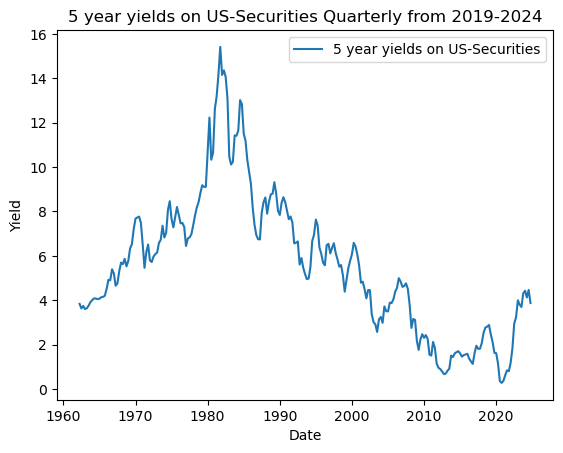

In [3]:
plt.plot(yields, label='5 year yields on US-Securities')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.title('5 year yields on US-Securities Quarterly from 2019-2024')
plt.legend()
plt.show()

In [4]:
def check_stationarity(ts):
    result = adfuller(ts.values.flatten())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

check_stationarity(yields['DGS5'])

ADF Statistic: -1.287502
p-value: 0.634870


In [5]:
kpss_result = kpss(yields['DGS5'])
print(kpss_result[1])

0.01


/var/folders/zn/gw_srj0x2d9c3gpr6_vc6vvr0000gn/T/ipykernel_13834/1955977334.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(yields['DGS5'])


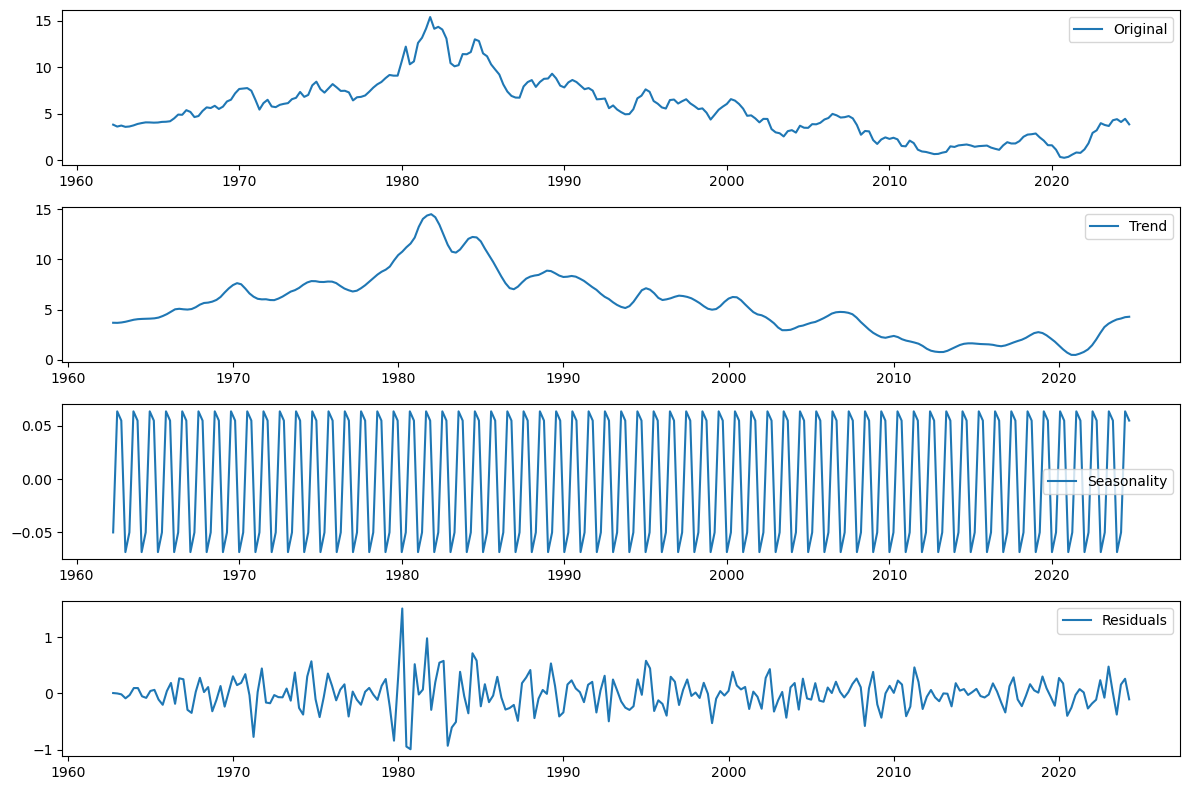

In [6]:
decomposition = seasonal_decompose(yields, model='additive')
   
    
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(yields, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
train = yields['DGS5'].iloc[:-74]
test = yields['DGS5'].iloc[-74:]

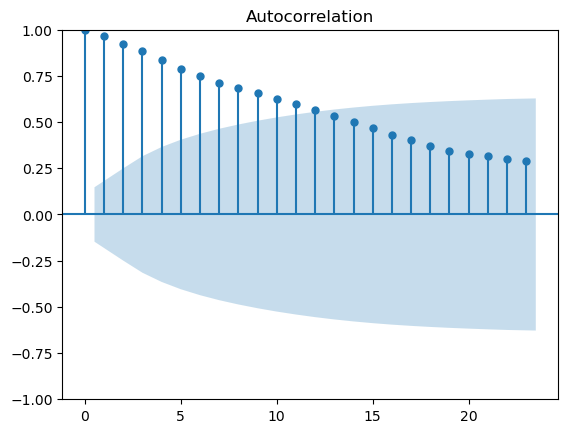

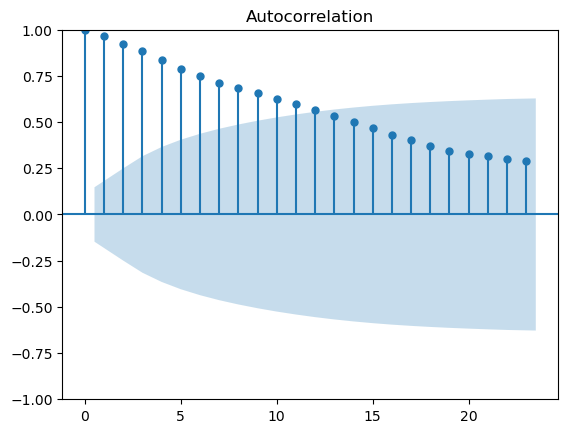

In [8]:
plot_acf(train)

In [9]:
train_detrended = (train - trend).dropna()


In [10]:
train_detrended

DATE
1962-09-30    0.062497
1962-12-31   -0.068034
1963-03-31   -0.065678
1963-06-30   -0.022413
1963-09-30    0.027727
                ...   
2005-03-31    0.133320
2005-06-30   -0.063429
2005-09-30   -0.091903
2005-12-31    0.037144
2006-03-31   -0.041966
Freq: QE-DEC, Length: 175, dtype: float64

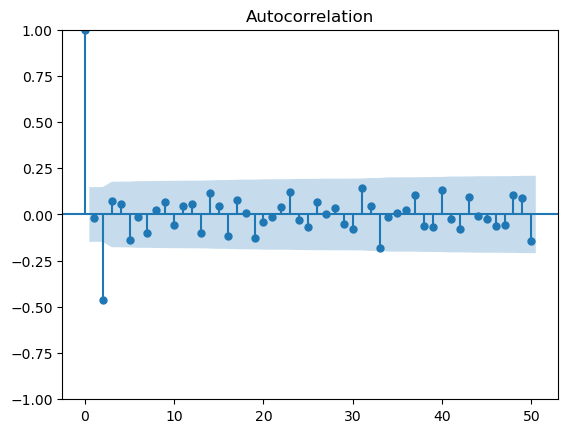

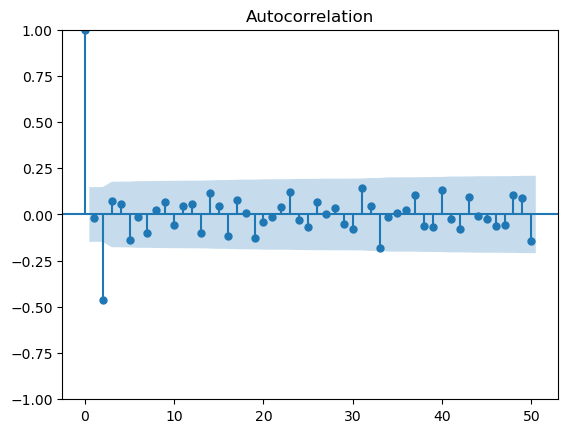

In [11]:
plot_acf(train_detrended,lags=50)

In [12]:
train_detrended_seasonality = train_detrended.diff(27).dropna()

In [13]:
train_detrended_seasonality

DATE
1969-06-30   -0.232537
1969-09-30    0.161605
1969-12-31    0.302335
1970-03-31    0.121126
1970-06-30    0.224557
                ...   
2005-03-31   -0.119507
2005-06-30   -0.112575
2005-09-30    0.503384
2005-12-31    0.180409
2006-03-31   -0.147534
Freq: QE-DEC, Length: 148, dtype: float64

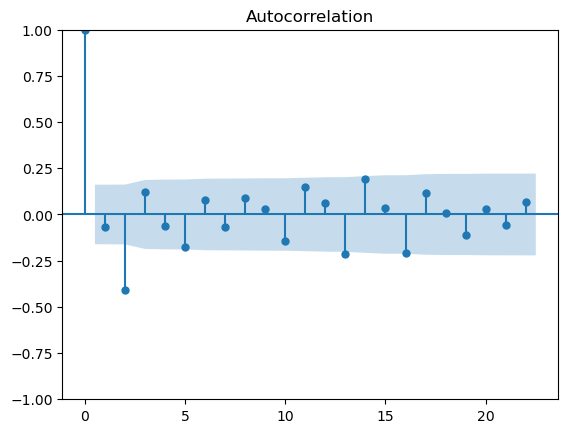

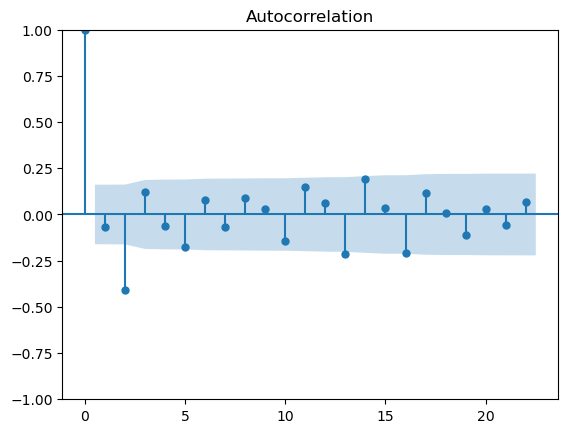

In [14]:
plot_acf(train_detrended_seasonality)

In [15]:
check_stationarity(train_detrended_seasonality)

ADF Statistic: -6.624219
p-value: 0.000000


In [16]:
kpss_result_detrended =  kpss(train_detrended_seasonality)
print(kpss_result_detrended[1])

0.1


/var/folders/zn/gw_srj0x2d9c3gpr6_vc6vvr0000gn/T/ipykernel_13834/397535079.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_detrended =  kpss(train_detrended_seasonality)


In [17]:
model = auto_arima(train,trace=True,seasonal=True,m=27,d=1)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[27] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(0,1,0)(0,0,0)[27] intercept   : AIC=323.171, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[27] intercept   : AIC=318.568, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[27] intercept   : AIC=313.928, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[27]             : AIC=321.179, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[27] intercept   : AIC=312.288, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[27] intercept   : AIC=313.965, Time=0.19 sec
 ARIMA(0,1,1)(1,0,1)[27] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(1,1,1)(0,0,0)[27] intercept   : AIC=311.071, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[27] intercept   : AIC=312.849, Time=0.38 sec
 ARIMA(1,1,1)(0,0,1)[27] intercept   : AIC=312.818, Time=0.32 sec
 ARIMA(1,1,1)(1,0,1)[27] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(1,1,0)(0,0,0)[27] intercept   : AIC=316.636, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[27] intercept   : AIC=312.185, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[27] intercept   : AIC=31

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  177
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -151.370
Date:                Sun, 22 Sep 2024   AIC                            308.740
Time:                        17:32:02   BIC                            318.252
Sample:                    03-31-1962   HQIC                           312.598
                         - 03-31-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2917      0.059      4.945      0.000       0.176       0.407
ma.L2         -0.1220      0.050     -2.461      0.014      -0.219      -0.025
sigma2         0.3267      0.024     13.793      0.000       0.280       0.373
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                47.35
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.50
Prob(H) (two-sided):                  0.22   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
error = model.resid()
q = acorr_ljungbox(error)
print(q)

     lb_stat  lb_pvalue
1   0.035192   0.851194
2   0.041961   0.979238
3   0.884465   0.829175
4   1.060524   0.900484
5   4.540796   0.474444
6   4.763479   0.574487
7   8.161666   0.318555
8   8.190011   0.415133
9   8.223577   0.511782
10  8.364830   0.593247


In [19]:
forecast,conf_int = model.predict(74,return_conf_int=True)

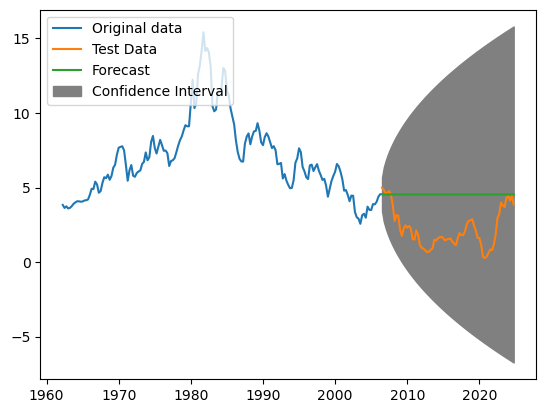

In [20]:
plt.plot(train,label='Original data')
plt.plot(test,label="Test Data")
plt.plot(forecast,label = "Forecast")
plt.fill_between(forecast.index,conf_int[:,0],conf_int[:,1],color="gray",label="Confidence Interval")
plt.legend(loc = "upper left")
plt.show()


In [21]:
model_triple = ExponentialSmoothing(
    yields, seasonal_periods=24, trend='add', seasonal='add')

model_triple_fit = model_triple.fit()


In [22]:
forecast_triple = model_triple_fit.forecast(12)
forecast_triple


2024-12-31    3.431047
2025-03-31    3.256940
2025-06-30    3.186221
2025-09-30    3.206848
2025-12-31    3.023774
2026-03-31    3.069285
2026-06-30    3.348105
2026-09-30    3.281204
2026-12-31    2.966934
2027-03-31    2.903995
2027-06-30    2.911169
2027-09-30    2.981008
Freq: QE-DEC, dtype: float64

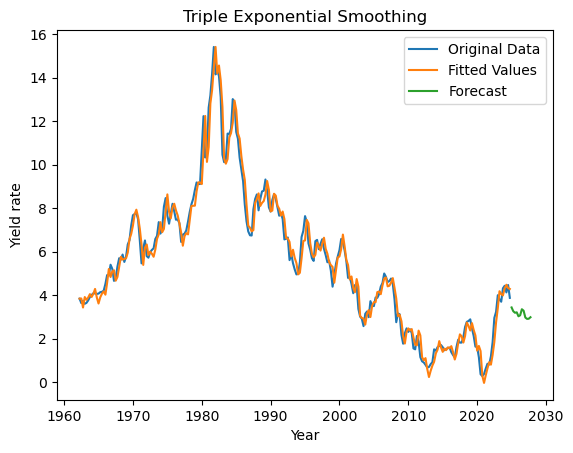

In [23]:
plt.plot(yields, label='Original Data')
plt.plot(model_triple_fit.fittedvalues, label='Fitted Values')
plt.plot(forecast_triple, label='Forecast')
plt.xlabel('Year')
plt.ylabel('Yield rate')
plt.title('Triple Exponential Smoothing')
plt.legend()
plt.show()
